In [1]:
!pip install pydicom
import os
import numpy as np
import pydicom
import pandas as pd
import shutil
from PIL import Image
from PIL import ImageEnhance
from skimage import exposure
from scipy import ndimage
import tensorflow as tf
import cv2
from sklearn.utils import shuffle
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Add
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K 

# !unzip /content/drive/MyDrive/iaaa-data-v2.zip -d /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
def load_dicom_image(path):
    dicom_data = pydicom.read_file(path)
    image = dicom_data.pixel_array.astype('uint16')
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    image = image.astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    factor = 1
    image_output = cv2.convertScaleAbs(image, alpha=factor)
    gray = cv2.cvtColor(np.array(image_output), cv2.COLOR_RGB2GRAY)
    kernel = np.array([
              [-1,-1,-1,-1,-1],
              [-1, 1, 1, 1,-1],
              [-1, 1, 9.5, 1,-1],
              [-1, 1, 1, 1,-1],
              [-1,-1,-1,-1,-1]]) / 4.0
    filtered = cv2.filter2D(gray, -1, kernel)
    gaussian_img = cv2.GaussianBlur(filtered, (0, 0), 1.5)
    imS = cv2.resize(gaussian_img, (1000, 500))
    crop = imS[120:400, 200:800]
    image = cv2.resize(crop, (512, 256))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

def load_mask(path, is_normal=False):
    if is_normal:
        mask = np.zeros((256, 512, 1), dtype=np.float32)
    else:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        imS = cv2.resize(mask, (1000, 500))
        crop = imS[120:400, 200:800]
        imS = cv2.resize(crop, (512, 256))
        mask = np.expand_dims(imS, axis=-1)
        mask = mask / 255.0
    return mask

def create_dataset(image_folder, mask_folder, normal_folder=None):
    image_files = os.listdir(image_folder)
    dataset = []
    normal_count = 0

    for image_file in image_files:
        if image_file.endswith('.png') or image_file.endswith('.dcm') and not image_file.startswith('._'):
            image_path = os.path.join(image_folder, image_file)
            mask_file = os.path.splitext(image_file)[0] + ".png"
            mask_path = os.path.join(mask_folder, mask_file)
            image = load_dicom_image(image_path)
            mask = load_mask(mask_path)
            dataset.append((image, mask))

    if normal_folder:
        normal_files = os.listdir(normal_folder)
        for normal_file in normal_files:
            if normal_file.endswith('.png') or normal_file.endswith('.dcm') and not normal_file.startswith('._'):
                if normal_count >= 100:
                    break
                normal_image_path = os.path.join(normal_folder, normal_file)
                normal_image = load_dicom_image(normal_image_path)
                normal_mask = load_mask('', is_normal=True)
                dataset.append((normal_image, normal_mask))
                normal_count += 1

    return dataset

In [6]:
image_folder = '/content/drive/MyDrive/abnormal'
mask_folder = '/content/drive/MyDrive/masks'
normal_folder = '/content/drive/MyDrive/normal'

dataset = create_dataset(image_folder, mask_folder, normal_folder)

np.random.shuffle(dataset)

train_size = int(0.9 * len(dataset))
train_dataset = dataset
val_dataset = dataset[train_size:]

In [7]:
print(len(train_dataset))

216


In [8]:
train_tf_dataset = tf.data.Dataset.from_generator(
    lambda: train_dataset,
    output_signature=(
        tf.TensorSpec(shape=(256, 512, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 512, 1), dtype=tf.float32)
    )
)
val_tf_dataset = tf.data.Dataset.from_generator(
    lambda: val_dataset,
    output_signature=(
        tf.TensorSpec(shape=(256, 512, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 512, 1), dtype=tf.float32)
    )
)

In [9]:
batch_size = 16
train_tf_dataset = train_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_tf_dataset = val_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

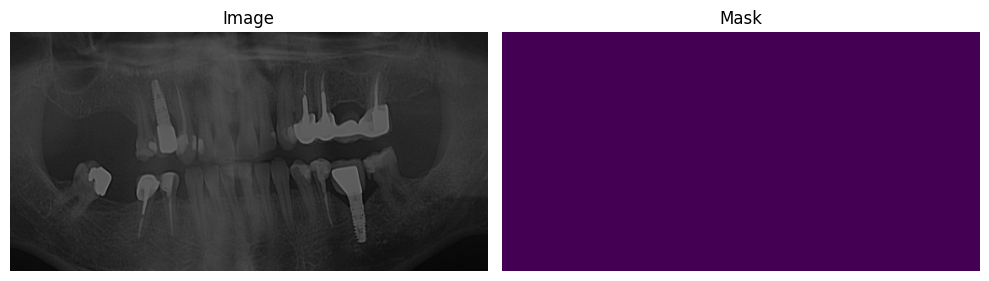

In [10]:
import matplotlib.pyplot as plt
def display_image_with_mask1(image, mask):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask)
    axes[1].set_title('Mask')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

image, mask = train_dataset[20]  
display_image_with_mask1(image, mask)

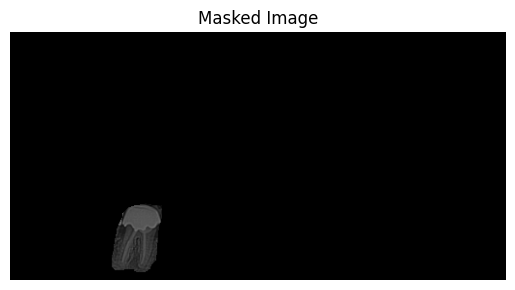

In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_image_with_mask2(image, mask):
    masked_image = cv2.bitwise_and(image.astype('uint8'), image.astype('uint8'), mask=mask.astype('uint8'))
    plt.imshow(masked_image)
    plt.title('Masked Image')
    plt.axis('off')
    plt.show()

image, mask = train_dataset[178]
display_image_with_mask2(image, mask)

In [11]:
# base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 512, 3], include_top=False)

# layer_names = [
#     'block_1_expand_relu',   # 64x64
#     'block_3_expand_relu',   # 32x32
#     'block_6_expand_relu',   # 16x16
#     'block_13_expand_relu',  # 8x8
#     'block_16_project',      # 4x4
# ]
# base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# down_stack.trainable = False

# base_model = tf.keras.applications.DenseNet121(input_shape=[256,512,3], include_top=False)
# layer_names = [
#     'conv1/relu', 
#     'pool2_conv', 
#     'pool3_conv', 
#     'pool4_conv',
#     'bn',
# ]
# base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# down_stack.trainable = False

# base_model = tf.keras.applications.MobileNet(input_shape=[256, 512, 3], include_top=False, weights='imagenet')

# layer_names = [
#     'conv_pw_1_relu',    # 64x64
#     'conv_pw_3_relu',    # 32x32
#     'conv_pw_5_relu',    # 16x16
#     'conv_pw_11_relu',   # 8x8
#     'conv_pw_13_relu',   # 4x4
# ]

# base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
# down_stack.trainable = False

import tensorflow as tf
base_model = tf.keras.applications.DenseNet169(input_shape=[256, 512, 3], include_top=False)
layer_names = [
    'conv1/relu',
    'pool2_conv',
    'pool3_conv',
    'pool4_conv',
    'bn',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

51877672/51877672 [==============================] - 0s 0us/step


In [12]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    down_stack
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3), 
    upsample(256, 3),  
    upsample(128, 3),  
    upsample(64, 3),   
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 512, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.image.resize(x, tf.shape(skip)[1:3])  
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, activation='sigmoid',
        padding='same')  

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 512, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.image.resize(x, tf.shape(skip)[1:3])  
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, activation='sigmoid',
        padding='same')  

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

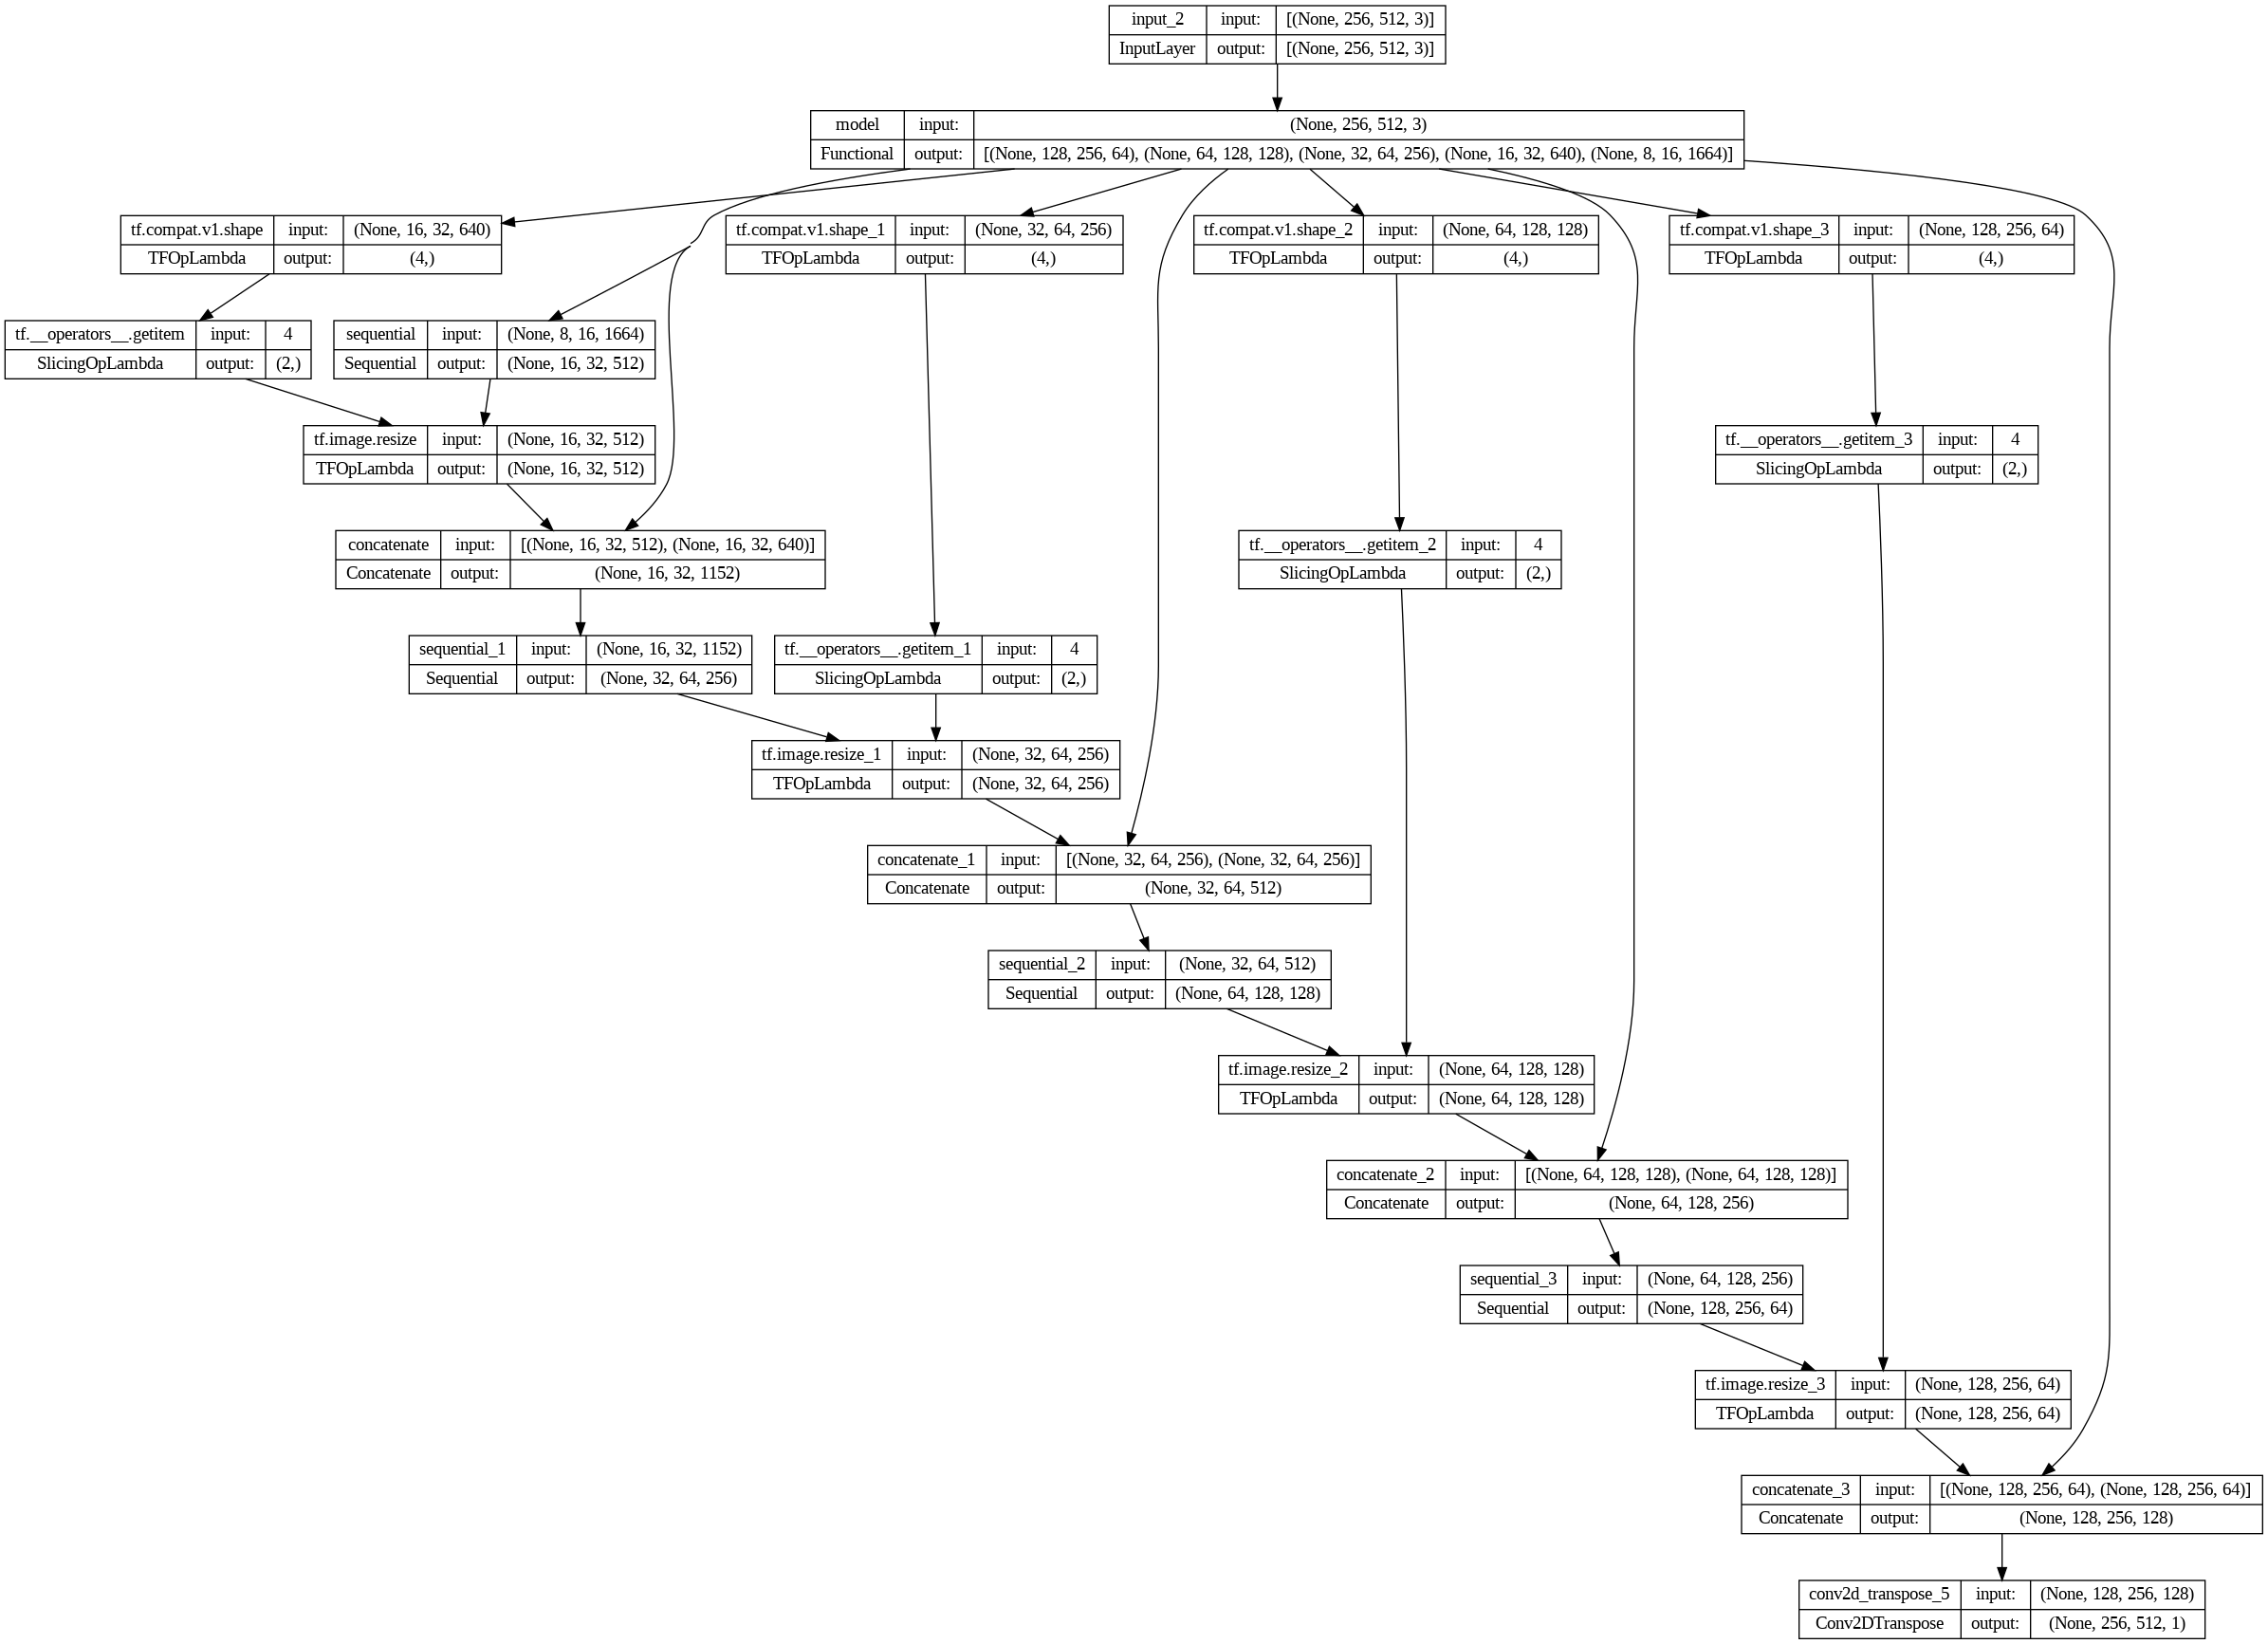

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
EPOCHS = 70
model_history = model.fit(train_tf_dataset, epochs=EPOCHS)

Epoch 1/70
14/14 [==============================] - 29s 654ms/step - loss: 0.9544 - dice_coef: 0.0460 - binary_accuracy: 0.6950
Epoch 2/70
14/14 [==============================] - 5s 340ms/step - loss: 0.9267 - dice_coef: 0.0744 - binary_accuracy: 0.8017
Epoch 3/70
14/14 [==============================] - 5s 336ms/step - loss: 0.8843 - dice_coef: 0.1175 - binary_accuracy: 0.8852
Epoch 4/70
14/14 [==============================] - 5s 333ms/step - loss: 0.8345 - dice_coef: 0.1672 - binary_accuracy: 0.9274
Epoch 5/70
14/14 [==============================] - 5s 336ms/step - loss: 0.7777 - dice_coef: 0.2244 - binary_accuracy: 0.9457
Epoch 6/70
14/14 [==============================] - 5s 326ms/step - loss: 0.7405 - dice_coef: 0.2604 - binary_accuracy: 0.9563
Epoch 7/70
14/14 [==============================] - 5s 329ms/step - loss: 0.7214 - dice_coef: 0.2812 - binary_accuracy: 0.9635
Epoch 8/70
14/14 [==============================] - 5s 322ms/step - loss: 0.7301 - dice_coef: 0.2734 - binary_

1/1 [==============================] - 5s 5s/step


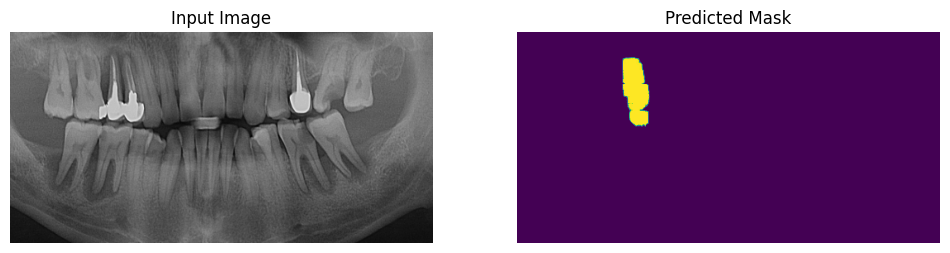

0.015054438
1


In [ ]:
img_size = [256,512]
def preprocess_dicom_image(image):
    dicom_data = pydicom.read_file(image)
    image = dicom_data.pixel_array.astype('uint16')
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    image = image.astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    factor = 1
    image_output = cv2.convertScaleAbs(image, alpha=factor)
    gray = cv2.cvtColor(np.array(image_output), cv2.COLOR_RGB2GRAY)
    kernel = np.array([
              [-1,-1,-1,-1,-1],
              [-1, 1, 1, 1,-1],
              [-1, 1, 9.5, 1,-1],
              [-1, 1, 1, 1,-1],
              [-1,-1,-1,-1,-1]]) / 4.0
    filtered = cv2.filter2D(gray, -1, kernel)
    gaussian_img = cv2.GaussianBlur(filtered, (0, 0), 1.5)
    imS = cv2.resize(gaussian_img, (1000, 500))
    crop = imS[120:400, 200:800]
    image = cv2.resize(crop, (512, 256))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

def predict_dicom_image(dicom_image):
    prediction = model.predict(dicom_image[tf.newaxis, ...])
    predicted_mask = prediction.reshape(img_size[0],img_size[1],1)  
    return predicted_mask

dicom_image_path = '/content/drive/MyDrive/abnormal/1.2.246.512.1.2.0.4.223935506356264.1897116244.20221229090707.dcm'
dicom_image = preprocess_dicom_image(dicom_image_path)
predicted_mask = predict_dicom_image(dicom_image)

def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
visualize([dicom_image, predicted_mask])

mask_value = np.mean(predicted_mask)
rounded_mask_value = round(mask_value, 7) 
mask_values = 1 if rounded_mask_value > 0.0100000  else 0
print(mask_value)
print(mask_values)

In [ ]:
def preprocess_dicom_image(image_path):
    dicom_data = pydicom.read_file(image_path)
    image = dicom_data.pixel_array.astype('uint16')
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    image = image.astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    factor = 1
    image_output = cv2.convertScaleAbs(image, alpha=factor)
    gray = cv2.cvtColor(np.array(image_output), cv2.COLOR_RGB2GRAY)
    kernel = np.array([
        [-1,-1,-1,-1,-1],
        [-1, 1, 1, 1,-1],
        [-1, 1, 9.5, 1,-1],
        [-1, 1, 1, 1,-1],
        [-1,-1,-1,-1,-1]]) / 4.0
    filtered = cv2.filter2D(gray, -1, kernel)
    gaussian_img = cv2.GaussianBlur(filtered, (0, 0), 1.5)
    imS = cv2.resize(gaussian_img, (1000, 500))
    crop = imS[120:400, 200:800]
    image = cv2.resize(crop, (512, 256))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

def predict_with_threshold(model, image, threshold):
    prediction = model.predict(image[tf.newaxis, ...])
    mask_value = np.mean(prediction)
    rounded_mask_value = round(mask_value, 7) 
    mask_value = 1 if rounded_mask_value > threshold else 0
    return mask_value

def evaluate_images(images_path, csv_path, model, threshold):
    dicom_list = os.listdir(images_path)
    labels = {"SOPInstanceUID": [], "Label": []}

    for dcm in dicom_list:
        if "dcm" == dcm.split(".")[-1]:
            image_path = os.path.join(images_path, dcm)
            dicom_image = preprocess_dicom_image(image_path)
            predicted_mask = predict_with_threshold(model, dicom_image, threshold)

            labels["SOPInstanceUID"].append(dcm[:-4])
            labels["Label"].append(predicted_mask)

    df = pd.DataFrame(labels)
    df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")

images_path = '/content/drive/MyDrive/abnormal'
csv_path = '/content/DesAB.csv'
model = model  
threshold = 0.0100000 
evaluate_images(images_path, csv_path, model, threshold)

1/1 [==============================] - 0s 44ms/step
Results saved to: /content/DesAB.csv


In [ ]:
model.save('DesNetU.h5')

In [ ]:
model_path = "/content/DesNetU.h5"
model_size = os.path.getsize(model_path) / (1024 * 1024)
print("حجم مدل: {:.2f} مگابایت".format(model_size))

حجم مدل: 175.85 مگابایت
